<a target="_blank" href="https://colab.research.google.com/github/jgomelop/ai4eng_CusFraDect/blob/master/4%20-%20Modelos%20No%20supervisados%20%2B%20supervisados.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!gdown https://drive.google.com/uc?id=1QoGQzRwfyK8hdYKKnnZa5YGokbAD0Ksy

Downloading...
From: https://drive.google.com/uc?id=1QoGQzRwfyK8hdYKKnnZa5YGokbAD0Ksy
To: /content/data_clean.zip
100% 51.8M/51.8M [00:00<00:00, 98.0MB/s]


In [2]:
!unzip data_clean.zip

Archive:  data_clean.zip
  inflating: test_clean.csv          
  inflating: train_clean.csv         


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, cross_val_score

from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import NMF


In [4]:
def report_cv_score(z):
    print ("test score   %.3f (±%.4f) with %d splits"%(np.mean(z["test_score"]), np.std(z["test_score"]), len(z["test_score"])))
    print ("train score  %.3f (±%.4f) with %d splits"%(np.mean(z["train_score"]), np.std(z["train_score"]), len(z["train_score"])))
    

In [5]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
  """
  From https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt/notebook

  """
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2    
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)    
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df
  

In [6]:
train = pd.read_csv("train_clean.csv", index_col=0)
train = reduce_mem_usage(train)
train.head()

Mem. usage decreased to 223.92 Mb (82.0% reduction)


,TransactionID,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,R_emaildomain_suffix_com,R_emaildomain_suffix_de,R_emaildomain_suffix_es,R_emaildomain_suffix_fr,R_emaildomain_suffix_jp,R_emaildomain_suffix_mx,R_emaildomain_suffix_nan,R_emaildomain_suffix_uk,R_emaildomain_suffix_us,isFraud
366215,3353215.0,49.00000,17184.0,321.0,150.0,226.0,310.0,87.0,8.0,2.0,...,0,0,0,0,0,0,1,0,0,0
437716,3424716.0,20.53125,17152.0,273.0,185.0,197.0,299.0,87.0,8.0,2.0,...,1,0,0,0,0,0,0,0,0,0
578692,3565692.0,22.00000,16312.0,400.0,150.0,224.0,123.0,87.0,8.0,1.0,...,1,0,0,0,0,0,0,0,0,0
364816,3351816.0,86.00000,12600.0,111.0,150.0,166.0,494.0,87.0,4.0,1.0,...,0,0,0,0,0,0,1,0,0,0
223792,3210792.0,236.00000,7480.0,490.0,150.0,226.0,325.0,87.0,8.0,111.0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
X_train = train.drop("isFraud", axis = 1)
X_train = reduce_mem_usage(X_train)
y_train = train["isFraud"]

Mem. usage decreased to 223.53 Mb (0.0% reduction)


In [8]:
test = pd.read_csv("test_clean.csv", index_col=0)
test = reduce_mem_usage(test)
test.head()

Mem. usage decreased to 95.63 Mb (82.1% reduction)


,TransactionID,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,R_emaildomain_suffix_com,R_emaildomain_suffix_de,R_emaildomain_suffix_es,R_emaildomain_suffix_fr,R_emaildomain_suffix_jp,R_emaildomain_suffix_mx,R_emaildomain_suffix_nan,R_emaildomain_suffix_uk,R_emaildomain_suffix_us,isFraud
470624,3457624.0,724.0000,7824.0,481.0,150.0,224.0,387.0,87.0,8.0,3.0,...,0,0,0,0,0,0,1,0,0,0
565820,3552820.0,108.5000,12544.0,321.0,150.0,226.0,476.0,87.0,0.0,2.0,...,0,0,0,0,0,0,1,0,0,0
284083,3271083.0,47.9375,9400.0,111.0,150.0,224.0,315.0,87.0,6.0,1.0,...,0,0,0,0,0,0,1,0,0,0
239689,3226689.0,100.6250,15888.0,545.0,185.0,138.0,299.0,87.0,8.0,2.0,...,1,0,0,0,0,0,0,0,0,0
281855,3268855.0,107.9375,15496.0,490.0,150.0,226.0,299.0,87.0,8.0,10.0,...,0,0,0,0,0,0,1,0,0,0


In [9]:
X_test = test.drop("isFraud", axis = 1)
X_test = reduce_mem_usage(X_test)
y_test = test["isFraud"]

Mem. usage decreased to 95.46 Mb (0.0% reduction)


# Modelos supervisados + PCA

In [10]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=5)
gnb = GaussianNB()

In [11]:
test_size = 0.3
val_size  = test_size/(1-test_size)

In [12]:
from sklearn.model_selection import cross_validate, ShuffleSplit

In [13]:
pca = PCA(n_components = 300)
Xt = pca.fit_transform(X_train)

In [14]:
zscores = []
estimators = [lr, dt, gnb]
for estimator in estimators:
    print("--")
    z = cross_validate(estimator, X_train, y_train, return_train_score=True, 
                       return_estimator=False,
                       scoring="roc_auc", 
                       cv=ShuffleSplit(n_splits=5, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(z["test_score"]))
best = np.argmax(zscores)
print ("selecting ", best)
best_estimator = estimators[best]
print ("\nselected model")
print (best_estimator)

--


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

test score   0.615 (±0.0227) with 5 splits
train score  0.613 (±0.0199) with 5 splits
--
test score   0.774 (±0.0048) with 5 splits
train score  0.779 (±0.0062) with 5 splits
--
test score   0.705 (±0.0049) with 5 splits
train score  0.707 (±0.0056) with 5 splits
selecting  1

selected model
DecisionTreeClassifier(max_depth=5)


In [15]:
pca = PCA(n_components = 300)
Xt_test = pca.fit_transform(X_test)

In [16]:

best_estimator.fit(Xt, y_train)

y_score = best_estimator.predict_proba(Xt_test)[:, 1]
reported_performance = roc_auc_score(y_true = y_test, y_score = y_score)
print ("reported performance of selectd model %.3f"%reported_performance)

reported performance of selectd model 0.703


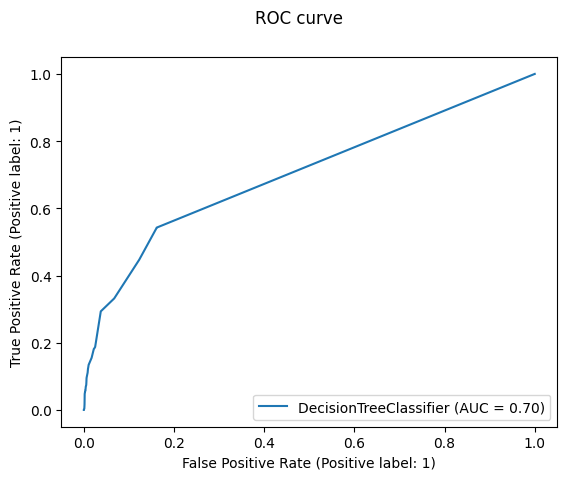

In [17]:
dt_disp = RocCurveDisplay.from_estimator(best_estimator, Xt_test, y_test)
dt_disp.figure_.suptitle("ROC curve ")
plt.show()

In [18]:
train_sizes, train_scores, valid_scores = learning_curve(best_estimator, Xt, y_train, 
                                                         train_sizes= [0.3, 0.5,0.7,0.9], 
                                                        scoring ='roc_auc', 
                                                         cv = ShuffleSplit(n_splits=10, test_size=val_size))

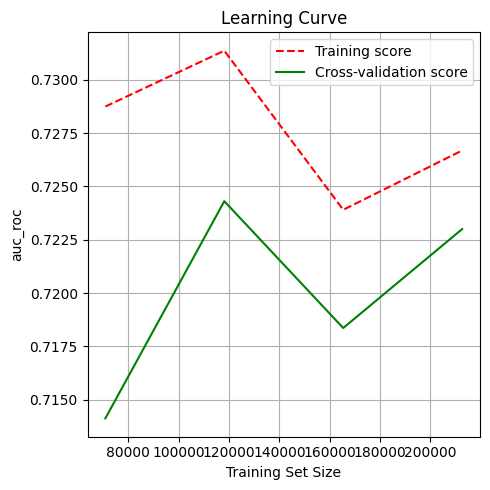

In [19]:
train_scores = np.abs(train_scores)
valid_scores = np.abs(valid_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.subplots(1, figsize=(5,5))
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



plt.grid()
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("auc_roc"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# NNF + Algoritmos supervisados

Buscamos las columnas con valores negativos


In [20]:
t = (X_train[X_train.columns] < 0).any()
t

TransactionID               False
TransactionAmt              False
card1                       False
card2                       False
card3                       False
                            ...  
R_emaildomain_suffix_jp     False
R_emaildomain_suffix_mx     False
R_emaildomain_suffix_nan    False
R_emaildomain_suffix_uk     False
R_emaildomain_suffix_us     False
Length: 393, dtype: bool

In [21]:
t.loc[ t == True]

D4       True
D11      True
D15      True
id_01    True
id_05    True
id_06    True
dtype: bool

In [22]:
t_test = (X_test[X_test.columns] < 0).any()
t_test

TransactionID               False
TransactionAmt              False
card1                       False
card2                       False
card3                       False
                            ...  
R_emaildomain_suffix_jp     False
R_emaildomain_suffix_mx     False
R_emaildomain_suffix_nan    False
R_emaildomain_suffix_uk     False
R_emaildomain_suffix_us     False
Length: 393, dtype: bool

In [23]:
t_test.loc[ t_test == True]

D4       True
D11      True
D15      True
id_01    True
id_05    True
id_06    True
dtype: bool

In [24]:
X_train_nmf = X_train.drop(['D4','D11','D15', 'id_01', 'id_05', 'id_06'], axis=1)
X_train_nmf = reduce_mem_usage(X_train_nmf)
X_test_nmf = X_test.drop(['D4','D11','D15', 'id_01', 'id_05', 'id_06'], axis = 1)
X_test_nmf = reduce_mem_usage(X_test_nmf)

Mem. usage decreased to 218.80 Mb (0.0% reduction)
Mem. usage decreased to 93.43 Mb (0.0% reduction)


In [25]:
components = [300, 250, 200]

perf = [] #desempeños de los modelos

dt = DecisionTreeClassifier(max_depth=5)

for i in components:
    nmf_tr = NMF(n_components = i)
    nmf_ts = NMF(n_components = i)

    X_tr = nmf_tr.fit_transform(X_train_nmf)
    X_ts = nmf_ts.fit_transform(X_test_nmf)
    
    dt.fit(X_tr, y_train)
    perf.append(roc_auc_score(y_test , dt.predict(X_ts)))
    print('roc_auc del modelo con ', i ,'elementos: ',"{:.5f}".format(perf[-1]))
    print('------------')

print('Mejor roc_auc: ',"{:.5f}".format(np.max(perf)),'  ; obtenido con ',components[np.argmax(perf)],' componentes para NMF')

roc_auc del modelo con  300 elementos:  0.50000
------------
roc_auc del modelo con  250 elementos:  0.50000
------------
roc_auc del modelo con  200 elementos:  0.50000
------------
Mejor roc_auc:  0.50000   ; obtenido con  300  componentes para NMF
